# Lennard Jones gas in NVT ensemble

In [34]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [35]:
# Parameter
# all in reduced units
N=100
T=1.5
rho=0.9
V=N/rho
L=V**(1/3)
print(rho,L,V)

0.9 4.807498567691361 111.11111111111111


In [36]:
#Lennard Jones potential truncated and shifted
rc=2.5
def u(i,j,r_c=rc):
    r=norm(i-(j+L*np.rint((i-j)/L)))
    if r>r_c: 
        return 0
    else:        
        return 4*(r**(-12)-r**(-6))#-r_c**(-12)+r_c**(-6)

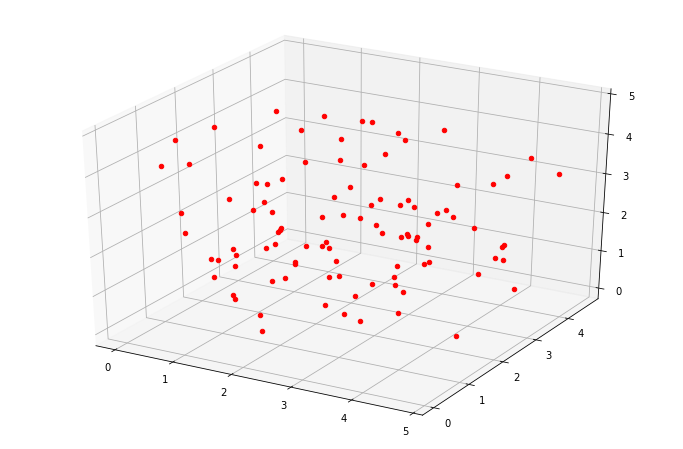

In [37]:
pos=[L*np.random.random(3) for i in range(N)]
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(projection='3d')
for x,y,z in pos:
    ax.scatter(x,y,z,'.',c='red')

In [38]:
# Cell list creation
##division of the square in more squares
nc=np.rint(L/rc).astype(int)
lc=L/nc
print(nc)

2


In [39]:
##function that returns index 
def int_cell(part):
    return [np.rint(part[j]/lc).astype(int)%nc for j in range(3)]

## Creation of the list §
## there are nc**3 elements
def cell_list(nc):
    c=[]
    for i in range(nc):
        c.append([])
        for j in range(nc):
            c[i].append([])
            for k in range(nc):
                c[i][j].append([])
    for i in range(N):
        n1,n2,n3=int_cell(pos[i])
        c[n1][n2][n3].append(i)
    return(c.copy())
c=cell_list(nc)

In [40]:
# check consistency
# See if the distance between particle in the same cell is less than sqrt(3)lc
R=[]
for cc in c[0][0][0]:
    R.append(pos[cc])
for i in range(len(R)):
    j=i+1
    while j<len(R):
        if not norm(R[i]-(R[j]+L*np.rint((R[i]-R[j])/L)))<lc*np.sqrt(3):
            print('Fatal error\n')
        j+=1
R.clear()

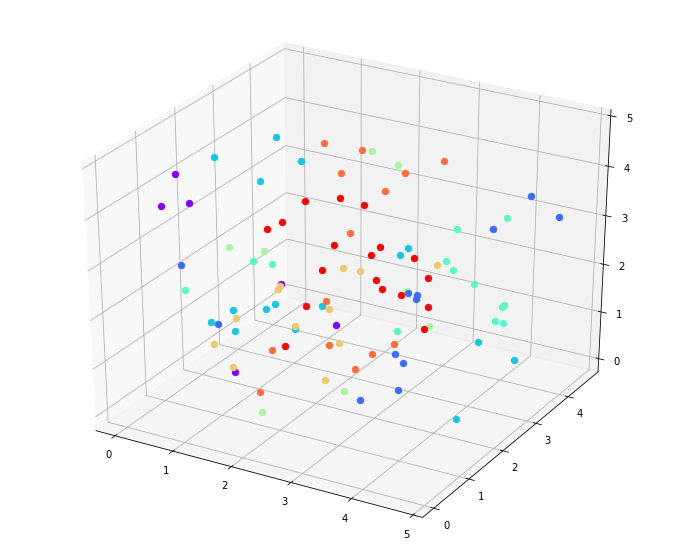

In [41]:
#Graphical view of the cell
#Doesn't help...

l=0
colors = cm.rainbow(np.linspace(0, 1, nc*nc*nc))
fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(projection='3d')
for i in range(nc):
    for j in range(nc):
        for k in range(nc):
            for cc in c[i][j][k]:
                if cc:
                    x,y,z = pos[cc]
                    ax.scatter(x,y,z,'.',color=colors[l],s=40)
            l+=1

In [56]:
#Energy evaluation
def en_nei(pp,p):
    ei=0.
    if nc>3:
        n1,n2,n3=int_cell(pp)
        for i in [-1+nc,nc,nc+1]:
            for j in [-1+nc,nc,nc+1]:
                for k in [-1+nc,nc,nc+1]:
                    ei+=sum([u(pp,pos[cc])/N for cc in c[(n1+i)%nc][(n2+j)%nc][(n3+k)%nc] if cc!=p and cc])
    else:
        for i in range(N):
            if i!=p:
                ei+=u(pp,pos[i])/N
    return ei

def en():
    e=0.
    for p in range(N):
        e+=en_nei(pos[p],p)*0.5
    return e
e=en()
e

37.22884300518611

In [43]:
e_p=0
for i in range(N):
    for j in range(N):
        if i!=j:
            e_p+=u(pos[i],pos[j])/N*0.5
e_p

3739999536.404738

In [44]:
#Check the best distance for the acceptance move
def mcmove_acc(d):
    C=c.copy()
    pos2=pos.copy()
    q=0
    for l in range(N):
        p=np.random.randint(0,N)
        xi=(pos2[p]+(0.5-np.random.random(3))*d+L)%L
        e0=0.
        e1=0.

        e0=en_nei(pos2[p],p)

        e1=en_nei(xi,p)
        
        if np.logical_or(e1<=e0,(e1>e0 and np.exp(-(e1-e0)/T)>np.random.random())):
            pos2[p]=xi
            n1,n2,n3=int_cell(xi)
            nn1,nn2,nn3=int_cell(pos2[p])
            if (p in C[nn1][nn2][nn3] and not np.all([n1,n2,n3]==[nn1,nn2,nn3])):
                C[nn1][nn2][nn3].remove(p)
                C[n1][n2][n3].append(p)
            q+=1
    print(q/N)

In [45]:
for i in range(10):
    mcmove_acc(0.04)

0.64
0.62
0.66
0.72
0.72
0.69
0.66
0.72
0.63
0.76


In [57]:
#mc move
# Move for 0.2 sigma
# update list 
def mcmove(c,e,step=0.2):
    for l in range(N):
        p=np.random.randint(0,N)
        xi=(pos[p]+(0.5-np.random.random(3))*step+L)%L
        e0=0.
        e1=0.
        e0=en_nei(pos[p],p)
        e1=en_nei(xi,p)
        
        if np.logical_or(e1<=e0,(e1>e0 and np.exp(-(e1-e0)/T)>np.random.random())):
            pos[p]=xi
            n1,n2,n3=int_cell(xi)
            nn1,nn2,nn3=int_cell(pos[p])
            e+=(e1-e0)
            if (not np.all([n1,n2,n3]==[nn1,nn2,nn3])):
                c[nn1][nn2][nn3].remove(p)
                c[n1][n2][n3].append(p)
            
    return(c.copy(),e)

In [58]:
Te=10000
file='pos.txt'
open(file,"w").close()
f=open(file,'a')
efile='energy.txt'
open(efile,"w").close()
g=open(efile,'a')
k=1
l=0
for t in range(Te):
    c,e=mcmove(c,e,0.05)
    if (t>l):
        g.write(f'{t} {e}\n')
        l=l*1.1+1
    if(t//100==k):
        np.savetxt(f,pos,header=f'{t} {e}',footer='\n')
        k+=1
    print("Loading " + str(int((t+1)/Te*100))+'%',end="\r")

f.close()
g.close()
del(g)
del(f)

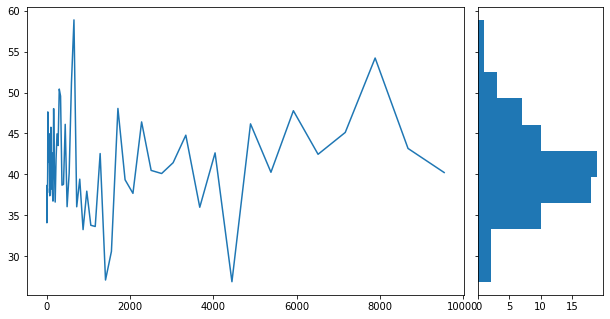

In [59]:
#plot temporal evolution of the energy and the histogram
te,E=np.loadtxt('energy.txt',unpack=True)
fig=plt.figure(figsize=(10,5))
gs=fig.add_gridspec(1,2,width_ratios=(7, 2),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)
ax.plot(te,E)
ax_histy.hist(E,orientation='horizontal')
ax_histy.tick_params(axis="y", labelleft=False)

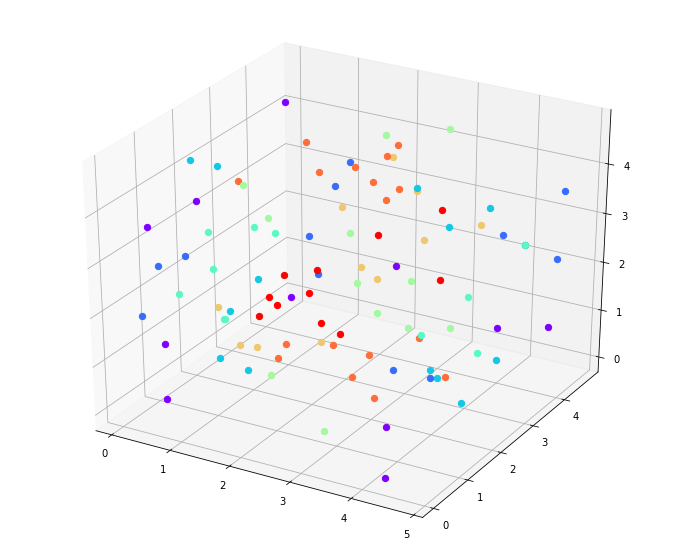

In [28]:
l=0
fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(projection='3d')
for i in range(nc):
    for j in range(nc):
        for k in range(nc):
            for cc in c[i][j][k]:
                if cc:
                    x,y,z = pos[cc]
                    ax.scatter(x,y,z,'.',color=colors[l],s=40)
            l+=1

In [207]:
#Save position
# the title are the parameters used
filename='pos_T_'+str(T)+'_rho_'+str(rho)+'_N_'+str(N)+'.txt'
np.savetxt(filename,pos)

## Radial Distribution function

In [176]:
#pos=np.loadtxt('pos.txt')

In [65]:
dr=0.07
R=5
nh=np.int((R+dr)/dr)
rr=np.linspace(0,R,nh+1)
delg=L/(2*nh)

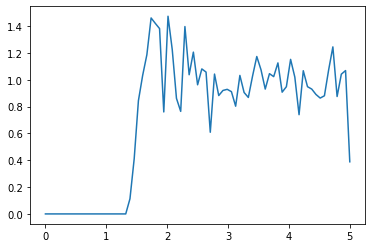

In [66]:
g=np.zeros(nh+1)
ng=0

def add_data(g,n_g=ng):
    for i in range(N-1):
        for j in range(i+1,N):
            r=norm(pos[i]-(pos[j]+L*np.rint((pos[i]-pos[j])/L)))
            if r<L/2:
                ig=np.rint(r/delg).astype(int)
                g[ig]+=2
    return(n_g+1)

def g_r(g,ng):
    G=g.copy()
    for i in range(len(G)):
        r=delg*(i+0.5)
        vb=((i+1)**3-i**3)*delg**3
        nid=4/3*np.pi*vb*rho
        G[i]=G[i]/(N*nid*ng)
    return G

ng=add_data(g,ng)
gg=g_r(g,ng)
plt.plot(rr,gg[:],'-')

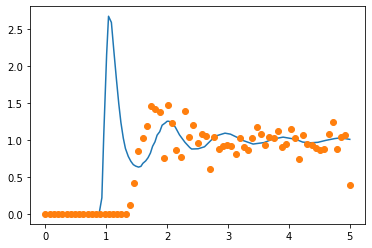

In [67]:
# comparison between the real and mine
(R,G)=np.loadtxt('radial_1.csv',delimiter=',',unpack=True)
plt.plot(R,G)
plt.plot(rr,gg[:],'o')

In [78]:
data=np.loadtxt(file)
for i in range(200,int(data.shape[0]/N)):
    pos=data[N*i:N*(i+1)]
    ng=add_data(g,ng)

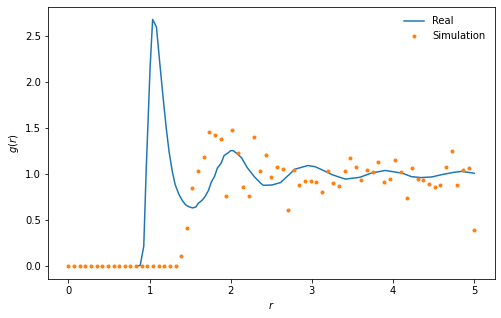

In [79]:
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot()
ax.plot(R,G,label='Real')
ax.plot(rr,gg[:],'.',label='Simulation')
ax.set_ylabel(r'$g(r)$')
ax.set_xlabel(r'$r$')
ax.legend(frameon=False)
#fig.savefig('g_T_'+str(T)+'_rho_'+str(rho)+'_N_'+str(N)+'.png')